Práctico entregable: 
Utilizar la base de jugadores “players_22.csv” disponible en la página de Kaggle https://www.kaggle.com/datasets/stefanoleone992/fifa-22-complete-player-dataset . Considerar que la base 2022 no tiene el mismo formato que la base vista en clase, a los nombres de las variables se les agregó una keyword para identificar a qué tipo de habilidad corresponde.

Con la nueva base, realizar un análisis análogo al que realizamos en el cursado de la materia con los datos FIFA2019. Realice comentarios en cada parte (verbose=True ;))

- Análisis exploratorio de la base.
- Evaluación visual  e intuitiva de a dos variables numéricas por vez.
- Uso de dos técnicas de clustering: por ejemplo k-medias, DBSCAN, mezcla de Gaussianas y/o alguna jerárquica. Elección justificada de hiper-parámetros
- Evaluación y Análisis de los clusters encontrados.
- Pregunta: ¿Se realizó alguna normalización o escalado de la base? ¿Por qué ?
- Uso de alguna transformación (proyección, Embedding) para visualizar los resultados y/o usarla como preprocesado para aplicar alguna técnica de clustering.

# Imports

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',1000)
import itertools
import warnings
warnings.filterwarnings("ignore")
import io
from plotly.offline import init_notebook_mode, plot,iplot
import plotly.graph_objs as go
init_notebook_mode(connected=True)
import matplotlib.pyplot as plt
import plotly.tools as tls#visualization
import plotly.figure_factory as ff#visualization
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from itertools import product
from sklearn.metrics import silhouette_score
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.pyplot import figure

# Lectura del dataset

In [2]:
df_1 = pd.read_csv('players_22.csv')

In [3]:
df_1.shape

(19239, 110)

In [4]:
df_1.columns.values

array(['sofifa_id', 'player_url', 'short_name', 'long_name',
       'player_positions', 'overall', 'potential', 'value_eur',
       'wage_eur', 'age', 'dob', 'height_cm', 'weight_kg', 'club_team_id',
       'club_name', 'league_name', 'league_level', 'club_position',
       'club_jersey_number', 'club_loaned_from', 'club_joined',
       'club_contract_valid_until', 'nationality_id', 'nationality_name',
       'nation_team_id', 'nation_position', 'nation_jersey_number',
       'preferred_foot', 'weak_foot', 'skill_moves',
       'international_reputation', 'work_rate', 'body_type', 'real_face',
       'release_clause_eur', 'player_tags', 'player_traits', 'pace',
       'shooting', 'passing', 'dribbling', 'defending', 'physic',
       'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'moveme

# Análisis del dataset

En este notebook, se pretende aplicar un análisis no supervisado para tratar de agrupar a los jugadores en sus posiciones en base a el profiling cuantitativo de sus caracteríticas. Un punto importante es **que posición vamos a considerar para cada jugador**?, ya que muchos jugadores tienen múltiples posiciones:

1- Campo denominado "Best Position": es el campo que se puede ver si se accede a la web del jugador. Esa "Best Position" proviene del valor de otro parámetro "Best Overall Rating", y corresponde a la posición con la máxima puntuación en la localización del campo de juego que se muestra en la cancha. Ejemplo: https://sofifa.com/player/158023 - Messi tiene una 'Best Position == CAM' derivada de un 'Best Overall Rating == 93'. Sin embargo, sus posiciones en el dataset no incluyen la posicion CAM (columna 'player_positions'). Por lo tanto la 'Best Position' y/o 'Best Overall Rating' no puede ser usada para los análisis no supervisados. De todas formas, si bien estos dos parámetros aparece en la web, no se encuentran presentes en el dataset. Igual, si los valores de características que si están en el dataset son los que originan de alguna maner el valor de 'Best Overall Rating' estamos ante una debilidad predictiva, porque, de nuevo: no usamos el 'Best Position' como localizador en la cancha.

2- Luego tenemos varias clasificaciones de posiciones: a- 'player_positions': es un listado de todas las posiciones en las que se ha probado el jugador, y parece ser un listado ordenado de prioridades de capacidad; b- 'club_position': es la posición que toma el jugador en su club. Necesariamente esta posición está presente en el listado anterior, con la salvedad de que si el jugador es suplente en su club, esta variable contiene el string 'RES'. Esto indica NO podemos usar la 'club_position' como referencia para los análisis porque todos los suplente (incluso los arqueros) caen en la misma categoría 'RES' si es que son suplentes. c- Luego tenemos 'nation_position': las posiciones acá no las podemos usar para el análisis general, dado que solo tenemos 759 jugadores de seleccion entre los mas de 19K jugadores en la base de datos. También entre los jugadores de selección tenemos la categoría de mayor ocurrencia que es 'SUB', suponemos que es suplente, con lo cual se nuclean de nuevo todas las posicione se pierde la capacidad descriptiva

**Conclusion**: a los fines de explorar una relación entre features y posición de juego, creemos conveniente tomar el listado 'player_positions', y utilizar la primer posición registrada que se asume como la mas caracterítica del jugador. Si tomamos de nuevo el ejemplo de Messi, vemos que el resultado es 'RW', que concide con la que juega en su club. Checkeamos que por ejemplo los suplentes en su club('RES' es 'club_position') tiene en el primer índice del listado su posición cacterística, lo cual es bueno.

# Análisis exploratorio

In [5]:
df_1.columns

Index(['sofifa_id', 'player_url', 'short_name', 'long_name',
       'player_positions', 'overall', 'potential', 'value_eur', 'wage_eur',
       'age',
       ...
       'lcb', 'cb', 'rcb', 'rb', 'gk', 'player_face_url', 'club_logo_url',
       'club_flag_url', 'nation_logo_url', 'nation_flag_url'],
      dtype='object', length=110)

In [6]:
columns_of_interest = ['short_name','player_positions','overall','attacking_crossing', 'attacking_finishing','attacking_heading_accuracy', 'attacking_short_passing',
                       'attacking_volleys', 'skill_dribbling', 'skill_curve','skill_fk_accuracy', 'skill_long_passing', 
                       'skill_ball_control','movement_acceleration', 'movement_sprint_speed','movement_agility', 
                       'movement_reactions', 'movement_balance','power_shot_power', 'power_jumping', 'power_stamina',
                       'power_strength', 'power_long_shots', 'mentality_aggression','mentality_interceptions', 'mentality_positioning',
                       'mentality_vision', 'mentality_penalties', 'mentality_composure','defending_marking_awareness', 
                       'defending_standing_tackle','defending_sliding_tackle', 'goalkeeping_diving','goalkeeping_handling', 
                       'goalkeeping_kicking','goalkeeping_positioning', 'goalkeeping_reflexes','goalkeeping_speed']



In [7]:
df_2=df_1[columns_of_interest]

In [8]:
df_2.isnull().sum()

short_name                         0
player_positions                   0
overall                            0
attacking_crossing                 0
attacking_finishing                0
attacking_heading_accuracy         0
attacking_short_passing            0
attacking_volleys                  0
skill_dribbling                    0
skill_curve                        0
skill_fk_accuracy                  0
skill_long_passing                 0
skill_ball_control                 0
movement_acceleration              0
movement_sprint_speed              0
movement_agility                   0
movement_reactions                 0
movement_balance                   0
power_shot_power                   0
power_jumping                      0
power_stamina                      0
power_strength                     0
power_long_shots                   0
mentality_aggression               0
mentality_interceptions            0
mentality_positioning              0
mentality_vision                   0
m

Tenemos muchos valores nulos, que corresponden a la variable 'goalkeeping_speed'. Eso se asume que ocurre porque los jugadores que no son arqueros no tienen medida esta característica. Por lo tanto, es seguro asignarle el valor: 0. 

Acá se hace el desarmado de la columna 'player_positions', y se asigna el primer lugar a una variable que llamamos 'reference_position'

In [9]:
df_2['reference_position'] = df_2['player_positions'].str.split(',',expand=True)[0]
df_2['reference_position'].value_counts()
df_2.fillna(0,inplace=True)

Acá verificamos que todos los jugadores tienen una posición de referencia en el campo y que no existe la categoría genérica de suplente.

In [10]:
df_2.columns

Index(['short_name', 'player_positions', 'overall', 'attacking_crossing',
       'attacking_finishing', 'attacking_heading_accuracy',
       'attacking_short_passing', 'attacking_volleys', 'skill_dribbling',
       'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
       'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed',
       'movement_agility', 'movement_reactions', 'movement_balance',
       'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength',
       'power_long_shots', 'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle',
       'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes', 'goalkeeping_speed',
       'reference_position'],
      dtype='object')

Vamos a generar nuevas variables que son excluivas para visualizar en 2D, y que vienen de la suma de las distintas características de los jugadores. Se crean categorías y se suman las características correspondientes. Las categorías se crearon en función de como están descriptos los jugadores en la página web.

In [11]:
attacking_overall = ['attacking_crossing','attacking_finishing', 'attacking_heading_accuracy','attacking_short_passing', 'attacking_volleys']
skill_overall = ['skill_dribbling','skill_curve', 'skill_fk_accuracy', 'skill_long_passing','skill_ball_control']
movement_overall = ['movement_sprint_speed', 'movement_agility', 'movement_reactions','movement_balance']
power_overall = ['power_shot_power', 'power_jumping','power_stamina', 'power_strength', 'power_long_shots']
mentality_overall = ['mentality_aggression', 'mentality_interceptions','mentality_positioning', 'mentality_vision', 'mentality_penalties','mentality_composure']
defending_overall = ['defending_marking_awareness','defending_standing_tackle', 'defending_sliding_tackle']
goalkeeping_overall = ['goalkeeping_diving', 'goalkeeping_handling','goalkeeping_kicking', 'goalkeeping_positioning','goalkeeping_reflexes', 'goalkeeping_speed']

full_overall_calculated = ['attacking_overall','skill_overall','movement_overall','power_overall','power_overall',
                           'mentality_overall','defending_overall','goalkeeping_overall']

# Generamos variables por categoría
df_2['attacking_overall'] = df_2[attacking_overall].sum(axis=1)
df_2['skill_overall'] = df_2[skill_overall].sum(axis=1)
df_2['movement_overall'] = df_2[movement_overall].sum(axis=1)
df_2['power_overall'] = df_2[power_overall].sum(axis=1)
df_2['mentality_overall'] = df_2[mentality_overall].sum(axis=1)
df_2['defending_overall'] = df_2[defending_overall].sum(axis=1)
df_2['goalkeeping_overall'] = df_2[goalkeeping_overall].sum(axis=1)

# Sumamos todas las variables globales
df_2['full_overall_calculated'] = df_2[full_overall_calculated].sum(axis=1)

df_2.columns

Index(['short_name', 'player_positions', 'overall', 'attacking_crossing',
       'attacking_finishing', 'attacking_heading_accuracy',
       'attacking_short_passing', 'attacking_volleys', 'skill_dribbling',
       'skill_curve', 'skill_fk_accuracy', 'skill_long_passing',
       'skill_ball_control', 'movement_acceleration', 'movement_sprint_speed',
       'movement_agility', 'movement_reactions', 'movement_balance',
       'power_shot_power', 'power_jumping', 'power_stamina', 'power_strength',
       'power_long_shots', 'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle',
       'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes', 'goalkeeping_speed',
       'reference_position', 'attacking_overall', 'skill_overall',


Vamos a crear dos dataframes: uno con las características originales (df_3) y otros con los resúmenes (df_4)

In [12]:
df_3 = df_2.drop(columns=['short_name','player_positions','reference_position','attacking_overall', 'skill_overall',
                          'movement_overall', 'power_overall', 'mentality_overall','defending_overall', 
                          'goalkeeping_overall', 'full_overall_calculated'])

df_4 = df_2[['attacking_overall', 'skill_overall','movement_overall', 'power_overall', 'mentality_overall',
             'defending_overall', 'goalkeeping_overall', 'full_overall_calculated']]

Chequeamos las columnas en cada dataframe con destino al clustering

In [13]:
print(df_3.columns)
print(df_4.columns)

Index(['overall', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle',
       'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes', 'goalkeeping_speed'],
      dtype='object')
Index(['attacking_overall', 'skill_overall', 'movement_overall',
       'power

Hacemos una matriz de correlación para ver si hay redundacia de información en las variables.

<AxesSubplot:>

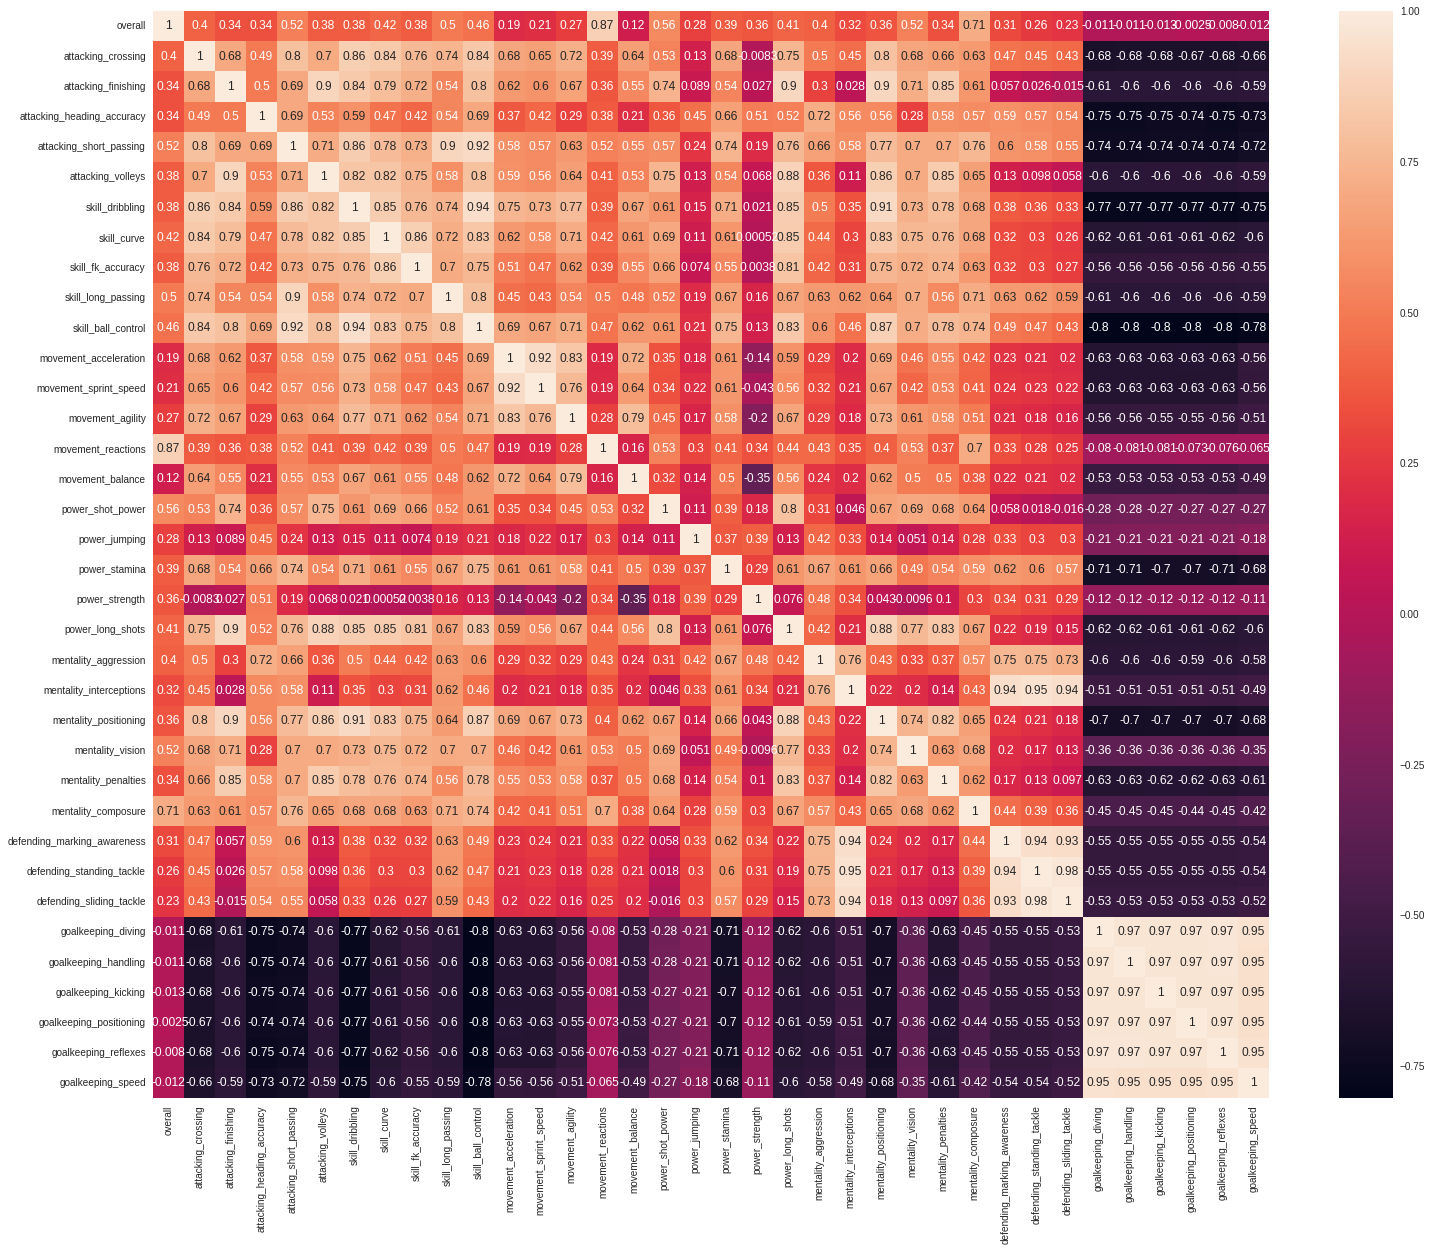

In [14]:
plt.figure(figsize=(25, 20))
corrMatrix = df_3.corr()
sns.heatmap(corrMatrix, annot=True)

No se observan altas correlaciones entre las variables. Lo más notorio es una correlación negativa entre los descriptores de arqueros (goalkeeping) y las capacidad de jugadores de campo. No es alta la correlación, pero si se nota que es inversa.

Hacemos una matriz de correlación para ver si hay redundacia de información en las variables

<AxesSubplot:>

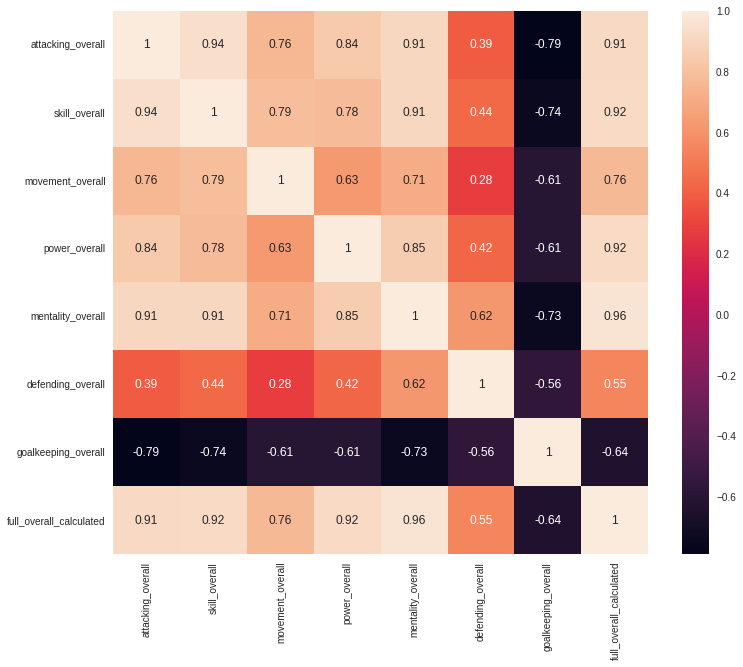

In [15]:
plt.figure(figsize=(12, 10))
corrMatrix = df_4.corr()
sns.heatmap(corrMatrix, annot=True)

Acá se observan altas correlaciones entre las variable overall calculadas. La excepción es el 'defending_overall', que parece ser muy específica de para un grupo de jugadores. Es conveniente basar el clustering en el dataframe no sumado (df_3)

Verificamos que todas las variables son numéricas

In [16]:
df_3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19239 entries, 0 to 19238
Data columns (total 36 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   overall                      19239 non-null  int64  
 1   attacking_crossing           19239 non-null  int64  
 2   attacking_finishing          19239 non-null  int64  
 3   attacking_heading_accuracy   19239 non-null  int64  
 4   attacking_short_passing      19239 non-null  int64  
 5   attacking_volleys            19239 non-null  int64  
 6   skill_dribbling              19239 non-null  int64  
 7   skill_curve                  19239 non-null  int64  
 8   skill_fk_accuracy            19239 non-null  int64  
 9   skill_long_passing           19239 non-null  int64  
 10  skill_ball_control           19239 non-null  int64  
 11  movement_acceleration        19239 non-null  int64  
 12  movement_sprint_speed        19239 non-null  int64  
 13  movement_agility

Acá definimos el dataframe que finalmente entrará al proceso de aprendizaje no supervisado.
- "analysis_dataframe": Corresponde al dataframe con las features numericas usadas para el modelo.
- "info_dataframe": Corresponde al dataframe con la información y las características usadas para describir las características.

In [17]:
analysis_dataframe = df_3
info_dataframe = df_2

In [51]:
analysis_dataframe

,overall,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
0,93,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,20,35,24,6,11,15,14,8,0.0
1,92,71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,85,76,86,87,81,49,95,81,90,88,35,42,19,15,6,12,8,10,0.0
2,91,87,95,90,80,86,88,81,84,77,88,85,88,86,94,74,94,95,77,77,93,63,29,95,76,88,95,24,32,24,7,11,15,14,11,0.0
3,91,85,83,63,86,86,95,88,87,81,95,93,89,96,89,84,80,64,81,53,81,63,37,86,90,93,93,35,32,29,9,9,15,15,11,0.0
4,91,94,82,55,94,82,88,85,83,93,91,76,76,79,91,78,91,63,89,74,91,76,66,88,94,83,89,68,65,53,15,13,5,10,13,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19234,47,46,32,48,50,30,45,33,38,48,49,56,60,55,53,70,46,62,51,46,30,52,42,38,43,42,37,38,43,48,6,10,5,15,13,0.0
19235,47,54,33,46,51,32,41,53,31,50,42,60,58,64,49,69,49,47,63,47,38,49,39,51,49,44,47,37,44,47,11,12,6,8,10,0.0
19236,47,39,32,43,49,37,47,37,37,49,49,60,60,58,46,59,50,57,56,50,34,51,38,45,46,39,36,38,44,48,8,6,7,10,6,0.0
19237,47,29,49,40,38,34,42,36,34,33,45,69,67,72,48,73,48,50,50,40,41,34,14,47,40,49,47,10,14,11,7,10,7,14,15,0.0


In [50]:
info_dataframe

,short_name,player_positions,overall,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,reference_position,attacking_overall,skill_overall,movement_overall,power_overall,mentality_overall,defending_overall,goalkeeping_overall,full_overall_calculated,KMeans_clust
0,L. Messi,"RW, ST, CF",93,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,20,35,24,6,11,15,14,8,0.0,RW,429,470,360,389,443,79,54.0,2613.0,3
1,R. Lewandowski,ST,92,71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,85,76,86,87,81,49,95,81,90,88,35,42,19,15,6,12,8,10,0.0,ST,430,407,331,424,484,96,51.0,2647.0,3
2,Cristiano Ronaldo,"ST, LW",91,87,95,90,80,86,88,81,84,77,88,85,88,86,94,74,94,95,77,77,93,63,29,95,76,88,95,24,32,24,7,11,15,14,11,0.0,ST,438,418,342,436,446,80,58.0,2654.0,3
3,Neymar Jr,"LW, CAM",91,85,83,63,86,86,95,88,87,81,95,93,89,96,89,84,80,64,81,53,81,63,37,86,90,93,93,35,32,29,9,9,15,15,11,0.0,LW,403,446,358,359,462,96,59.0,2542.0,3
4,K. De Bruyne,"CM, CAM",91,94,82,55,94,82,88,85,83,93,91,76,76,79,91,78,91,63,89,74,91,76,66,88,94,83,89,68,65,53,15,13,5,10,13,0.0,CM,407,440,324,408,496,186,56.0,2725.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19234,Song Defu,CDM,47,46,32,48,50,30,45,33,38,48,49,56,60,55,53,70,46,62,51,46,30,52,42,38,43,42,37,38,43,48,6,10,5,15,13,0.0,CDM,206,213,238,235,254,129,49.0,1559.0,4
19235,C. Porter,CM,47,54,33,46,51,32,41,53,31,50,42,60,58,64,49,69,49,47,63,47,38,49,39,51,49,44,47,37,44,47,11,12,6,8,10,0.0,CM,216,217,240,244,279,128,47.0,1615.0,2
19236,N. Logue,CM,47,39,32,43,49,37,47,37,37,49,49,60,60,58,46,59,50,57,56,50,34,51,38,45,46,39,36,38,44,48,8,6,7,10,6,0.0,CM,200,219,223,247,255,130,37.0,1558.0,4
19237,L. Rudden,ST,47,29,49,40,38,34,42,36,34,33,45,69,67,72,48,73,48,50,50,40,41,34,14,47,40,49,47,10,14,11,7,10,7,14,15,0.0,ST,190,190,260,229,231,35,53.0,1417.0,2


In [49]:
analysis_dataframe

,overall,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed
0,93,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,20,35,24,6,11,15,14,8,0.0
1,92,71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,85,76,86,87,81,49,95,81,90,88,35,42,19,15,6,12,8,10,0.0
2,91,87,95,90,80,86,88,81,84,77,88,85,88,86,94,74,94,95,77,77,93,63,29,95,76,88,95,24,32,24,7,11,15,14,11,0.0
3,91,85,83,63,86,86,95,88,87,81,95,93,89,96,89,84,80,64,81,53,81,63,37,86,90,93,93,35,32,29,9,9,15,15,11,0.0
4,91,94,82,55,94,82,88,85,83,93,91,76,76,79,91,78,91,63,89,74,91,76,66,88,94,83,89,68,65,53,15,13,5,10,13,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19234,47,46,32,48,50,30,45,33,38,48,49,56,60,55,53,70,46,62,51,46,30,52,42,38,43,42,37,38,43,48,6,10,5,15,13,0.0
19235,47,54,33,46,51,32,41,53,31,50,42,60,58,64,49,69,49,47,63,47,38,49,39,51,49,44,47,37,44,47,11,12,6,8,10,0.0
19236,47,39,32,43,49,37,47,37,37,49,49,60,60,58,46,59,50,57,56,50,34,51,38,45,46,39,36,38,44,48,8,6,7,10,6,0.0
19237,47,29,49,40,38,34,42,36,34,33,45,69,67,72,48,73,48,50,50,40,41,34,14,47,40,49,47,10,14,11,7,10,7,14,15,0.0


# K-Means

Lo primero que hacemos es intentar el algoritmo mas general que es el K-means. Para eso, una exploración del número de clusters a usar viene bien, dado que es un hiperparámetros que se requiere definir como parte de la corrida del algoritmo. Emplearemos el método del codo basado en el cálculo de la inercia.

Se calcula la cantidad de posiciones para verificar si es posible lograr un cluster por posicion.

In [18]:
print("Cantidad de posiciones: " + str(len(df_2['reference_position'].value_counts().to_list())))

Cantidad de posiciones: 15


Verificamos si el numero de clusters seleccionado es correcto entre 2 y 15 clusters que es el máximo de posiciones.

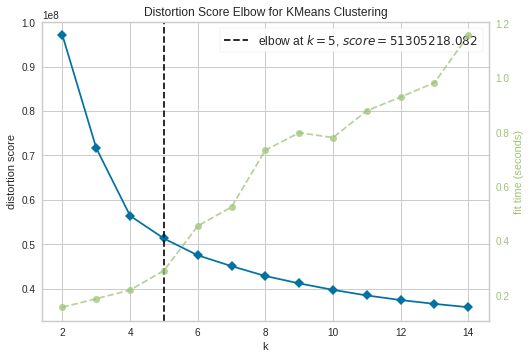

In [19]:
model = KMeans(random_state=7)
visualizer = KElbowVisualizer(model, k=(2,15))

visualizer.fit(analysis_dataframe)
visualizer.show()
plt.show()

Analizando el gráfico, vemos que el método de elbow basado en la incercia y su distorción indica que K=5 sería apropiado.

Nuestra primera hipótesis era que ibamos a tener 4 clusters debido a que son las 4 posiciones más generales (1-arqueros, 2-defensores, 3-mediocampistas, 4-delanteros), pero como vemos en el gráfico anterior, lo correcto seria utilizar K=5.
- Usamos la semilla con 'random_state' y 'k-means++' para inicializar con centroides alejados.
- Utilizamos todas las dimensiones (36 en total)
- Agregamos los labels de cluster en el dataframe original
- Guardamos los centros del cluster en el dataframe original

In [20]:
n_clust = 5
km = KMeans(n_clusters=n_clust,random_state=7,init='k-means++') 
km.fit(analysis_dataframe) 

info_dataframe['KMeans_clust'] = km.labels_

list_of_centers = km.cluster_centers_[:,1].tolist()

In [21]:
info_dataframe.head()

,short_name,player_positions,overall,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,reference_position,attacking_overall,skill_overall,movement_overall,power_overall,mentality_overall,defending_overall,goalkeeping_overall,full_overall_calculated,KMeans_clust
0,L. Messi,"RW, ST, CF",93,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,20,35,24,6,11,15,14,8,0.0,RW,429,470,360,389,443,79,54.0,2613.0,3
1,R. Lewandowski,ST,92,71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,85,76,86,87,81,49,95,81,90,88,35,42,19,15,6,12,8,10,0.0,ST,430,407,331,424,484,96,51.0,2647.0,3
2,Cristiano Ronaldo,"ST, LW",91,87,95,90,80,86,88,81,84,77,88,85,88,86,94,74,94,95,77,77,93,63,29,95,76,88,95,24,32,24,7,11,15,14,11,0.0,ST,438,418,342,436,446,80,58.0,2654.0,3
3,Neymar Jr,"LW, CAM",91,85,83,63,86,86,95,88,87,81,95,93,89,96,89,84,80,64,81,53,81,63,37,86,90,93,93,35,32,29,9,9,15,15,11,0.0,LW,403,446,358,359,462,96,59.0,2542.0,3
4,K. De Bruyne,"CM, CAM",91,94,82,55,94,82,88,85,83,93,91,76,76,79,91,78,91,63,89,74,91,76,66,88,94,83,89,68,65,53,15,13,5,10,13,0.0,CM,407,440,324,408,496,186,56.0,2725.0,3


Hacemos un análisis descriptivo de las posiciones de jugadores que resultan en cada cluster, tratando de asociar las caracteríticas del jugador con las necesidades ideales de la posición. Se puede ver un resúmen teórico en:
https://es.wikipedia.org/wiki/Posiciones_del_f%C3%BAtbol

Dividimos el dataframe por cada cluster generado a los fines de poder ver que jugadores hay.

In [22]:
for cluster_nbr in range(n_clust):
    globals()["df_cluster_"+str(cluster_nbr)] = info_dataframe[info_dataframe['KMeans_clust'] == cluster_nbr]

In [23]:
df_cluster_0['reference_position'].value_counts()

CM     1660
CDM    1114
LB      760
RB      702
CB      487
CAM     198
RM      171
LM      150
LWB     113
RWB     100
RW       33
ST       23
LW       23
CF        8
Name: reference_position, dtype: int64

Si vemos la distribución del cluster 0, podemos ver que son mayoritariamente defensores, con una amplia mayoria de centrales ("CB").

In [24]:
df_cluster_1['reference_position'].value_counts()

GK    2132
Name: reference_position, dtype: int64

Vemos la distribución de posisiones del cluster 1, y vemos que tiene mayoritariamente jugadores de contención, que incluye mediocampistas centrales ("CM") y defensores de contención ("CDM").

In [25]:
df_cluster_2['reference_position'].value_counts()

ST     1533
RM      456
LM      427
CAM     398
RW      268
LW      237
CM      184
CF       44
LB       12
RB        7
RWB       3
CDM       2
Name: reference_position, dtype: int64

Hacemos lo mismo con el cluster 2, y tiene exclusicamente arqueros. Esto nos sirve de referencia para saber que el cluster funcionó a la perfección, ya que no encontramos otro tipo de jugador en este cluster.

In [26]:
df_cluster_3['reference_position'].value_counts()

ST     1049
CAM     549
LM      423
RM      379
RW      193
LW      174
CF       90
CM       79
Name: reference_position, dtype: int64

El cluster 3 tiene delanteros centrales con mayoria de posiciones "ST"

In [27]:
df_cluster_4['reference_position'].value_counts()

CB     2852
RB      637
LB      588
CDM     549
CM      250
RWB      75
LWB      58
RM       22
LM       16
CAM       6
ST        3
RW        1
LW        1
Name: reference_position, dtype: int64

El cluster 4 tiene mayoritariamente defensores, con amplia mayoria de defensores centrales ("CB").

## Visualizaciones

Vamos a plotear en 2D las dimensiones generales de los jugadores, que son las que hemos creado a partir de la sumatoria de las dimensiones específicas.

<AxesSubplot:xlabel='full_overall_calculated', ylabel='goalkeeping_overall'>

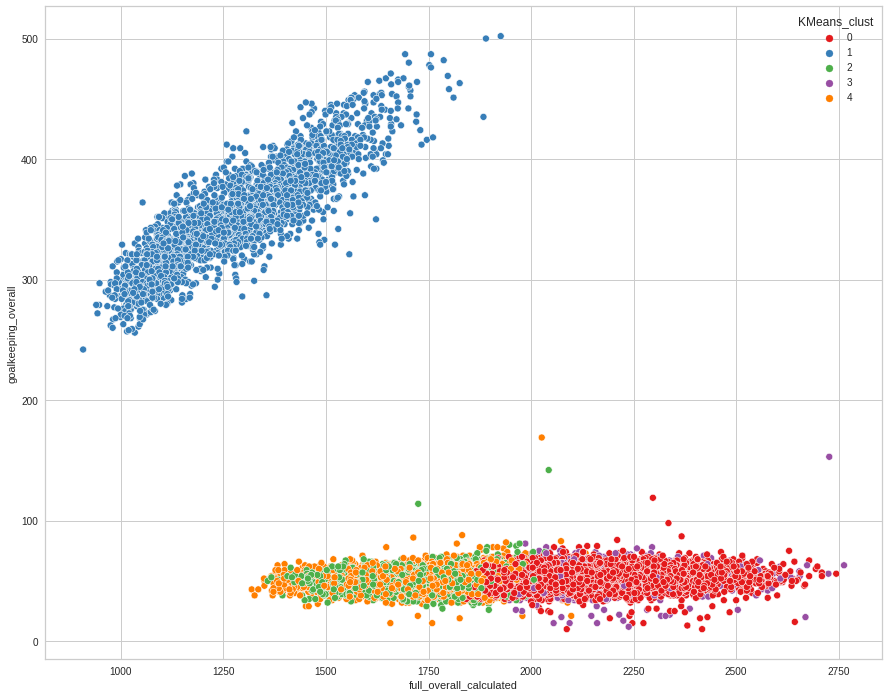

In [28]:
figure(figsize=(15, 12))
sns.scatterplot('full_overall_calculated', 'goalkeeping_overall', data=info_dataframe,
            hue='KMeans_clust', palette='Set1', legend='full')



<AxesSubplot:xlabel='full_overall_calculated', ylabel='attacking_overall'>

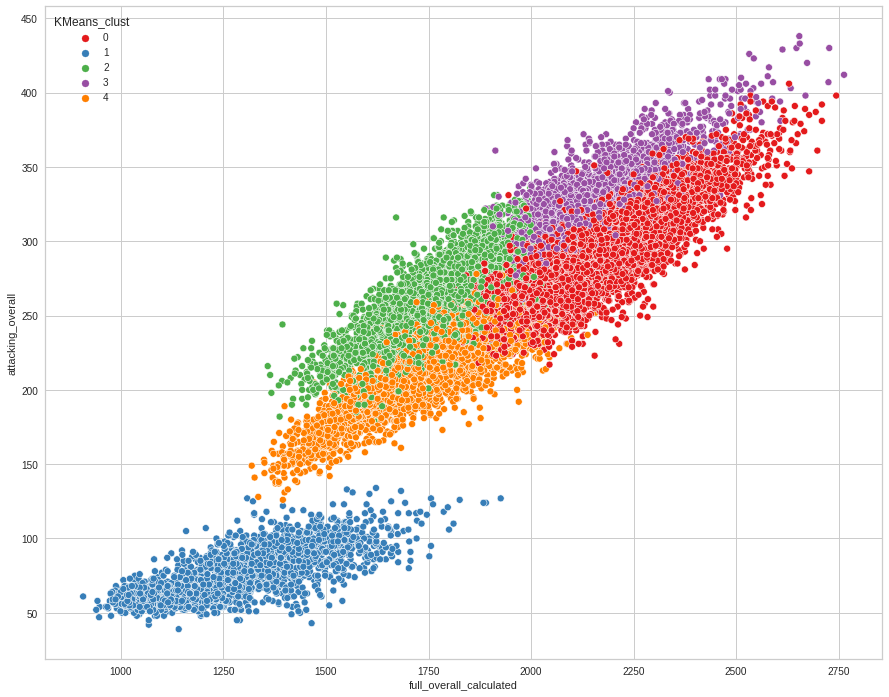

In [29]:
figure(figsize=(15, 12))
sns.scatterplot('full_overall_calculated', 'attacking_overall', data=info_dataframe,
            hue='KMeans_clust', palette='Set1', legend='full')

In [30]:
info_dataframe

,short_name,player_positions,overall,attacking_crossing,attacking_finishing,attacking_heading_accuracy,attacking_short_passing,attacking_volleys,skill_dribbling,skill_curve,skill_fk_accuracy,skill_long_passing,skill_ball_control,movement_acceleration,movement_sprint_speed,movement_agility,movement_reactions,movement_balance,power_shot_power,power_jumping,power_stamina,power_strength,power_long_shots,mentality_aggression,mentality_interceptions,mentality_positioning,mentality_vision,mentality_penalties,mentality_composure,defending_marking_awareness,defending_standing_tackle,defending_sliding_tackle,goalkeeping_diving,goalkeeping_handling,goalkeeping_kicking,goalkeeping_positioning,goalkeeping_reflexes,goalkeeping_speed,reference_position,attacking_overall,skill_overall,movement_overall,power_overall,mentality_overall,defending_overall,goalkeeping_overall,full_overall_calculated,KMeans_clust
0,L. Messi,"RW, ST, CF",93,85,95,70,91,88,96,93,94,91,96,91,80,91,94,95,86,68,72,69,94,44,40,93,95,75,96,20,35,24,6,11,15,14,8,0.0,RW,429,470,360,389,443,79,54.0,2613.0,3
1,R. Lewandowski,ST,92,71,95,90,85,89,85,79,85,70,88,77,79,77,93,82,90,85,76,86,87,81,49,95,81,90,88,35,42,19,15,6,12,8,10,0.0,ST,430,407,331,424,484,96,51.0,2647.0,3
2,Cristiano Ronaldo,"ST, LW",91,87,95,90,80,86,88,81,84,77,88,85,88,86,94,74,94,95,77,77,93,63,29,95,76,88,95,24,32,24,7,11,15,14,11,0.0,ST,438,418,342,436,446,80,58.0,2654.0,3
3,Neymar Jr,"LW, CAM",91,85,83,63,86,86,95,88,87,81,95,93,89,96,89,84,80,64,81,53,81,63,37,86,90,93,93,35,32,29,9,9,15,15,11,0.0,LW,403,446,358,359,462,96,59.0,2542.0,3
4,K. De Bruyne,"CM, CAM",91,94,82,55,94,82,88,85,83,93,91,76,76,79,91,78,91,63,89,74,91,76,66,88,94,83,89,68,65,53,15,13,5,10,13,0.0,CM,407,440,324,408,496,186,56.0,2725.0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19234,Song Defu,CDM,47,46,32,48,50,30,45,33,38,48,49,56,60,55,53,70,46,62,51,46,30,52,42,38,43,42,37,38,43,48,6,10,5,15,13,0.0,CDM,206,213,238,235,254,129,49.0,1559.0,4
19235,C. Porter,CM,47,54,33,46,51,32,41,53,31,50,42,60,58,64,49,69,49,47,63,47,38,49,39,51,49,44,47,37,44,47,11,12,6,8,10,0.0,CM,216,217,240,244,279,128,47.0,1615.0,2
19236,N. Logue,CM,47,39,32,43,49,37,47,37,37,49,49,60,60,58,46,59,50,57,56,50,34,51,38,45,46,39,36,38,44,48,8,6,7,10,6,0.0,CM,200,219,223,247,255,130,37.0,1558.0,4
19237,L. Rudden,ST,47,29,49,40,38,34,42,36,34,33,45,69,67,72,48,73,48,50,50,40,41,34,14,47,40,49,47,10,14,11,7,10,7,14,15,0.0,ST,190,190,260,229,231,35,53.0,1417.0,2


<AxesSubplot:xlabel='full_overall_calculated', ylabel='attacking_finishing'>

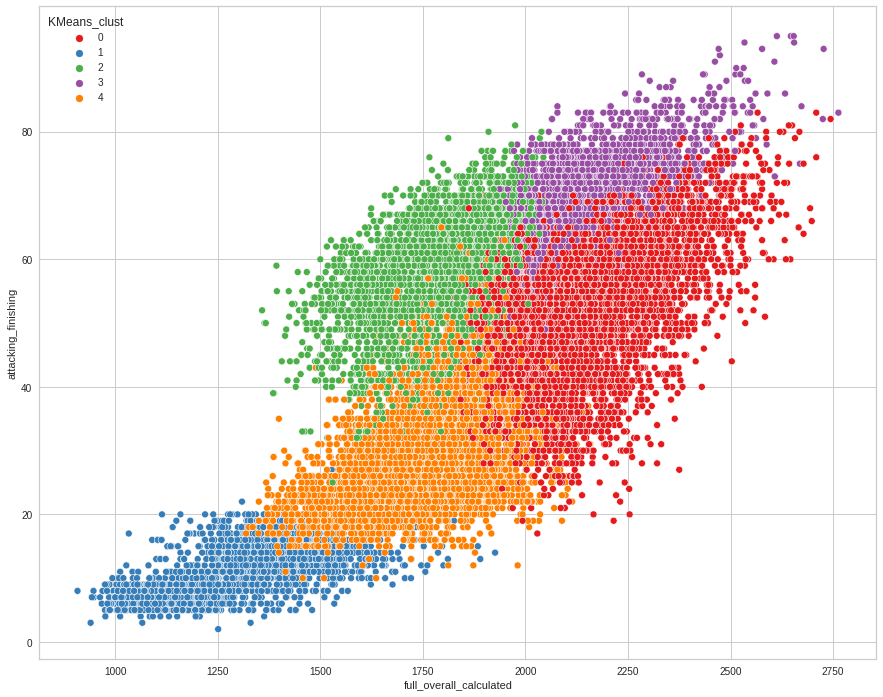

In [31]:
figure(figsize=(15, 12))
sns.scatterplot('full_overall_calculated', 'attacking_finishing', data=info_dataframe,
            hue='KMeans_clust', palette='Set1', legend='full')

<AxesSubplot:xlabel='full_overall_calculated', ylabel='defending_overall'>

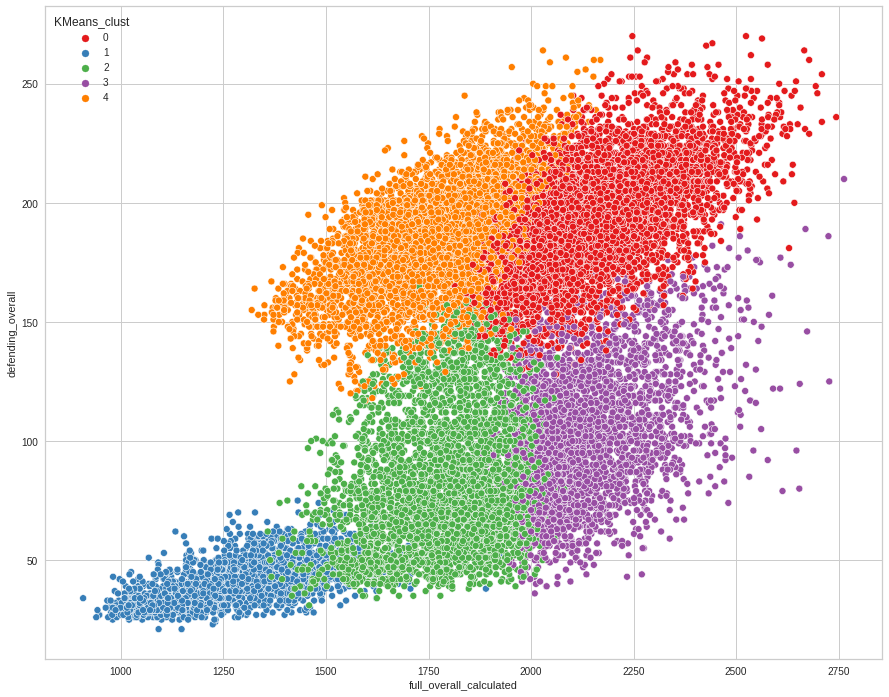

In [32]:
figure(figsize=(15, 12))
sns.scatterplot('full_overall_calculated', 'defending_overall', data=info_dataframe,
            hue='KMeans_clust', palette='Set1', legend='full')

<AxesSubplot:xlabel='full_overall_calculated', ylabel='skill_dribbling'>

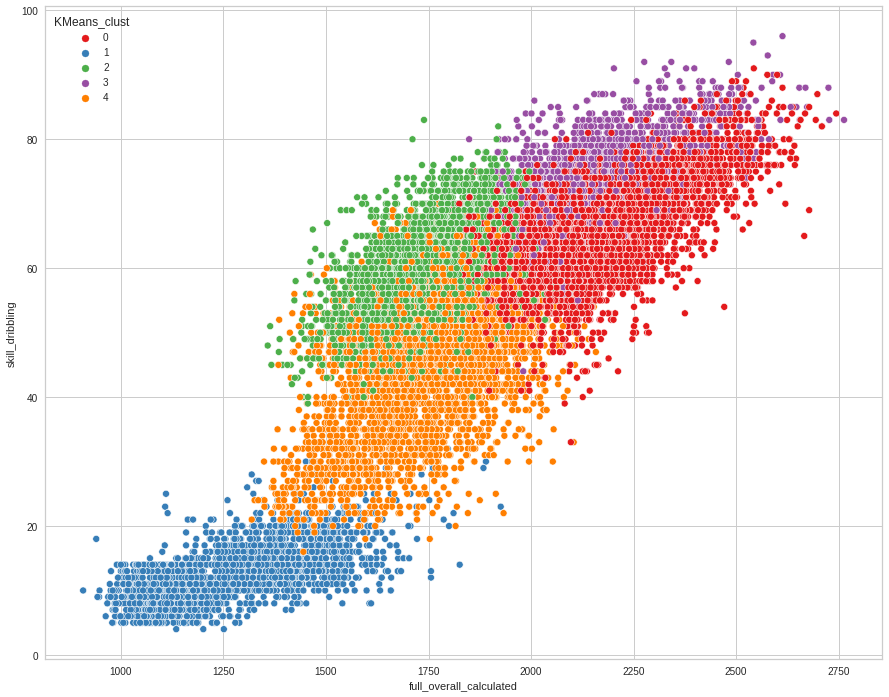

In [33]:
figure(figsize=(15, 12))
sns.scatterplot('full_overall_calculated', 'skill_dribbling', data=info_dataframe,
            hue='KMeans_clust', palette='Set1', legend='full')

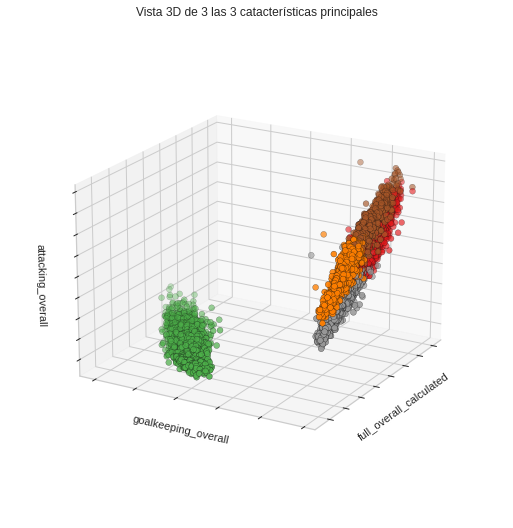

In [34]:
fig = plt.figure(figsize=(7, 7))
ax = Axes3D(fig, rect=[0, 0, .99, 1], elev=20, azim=210)
ax.scatter(info_dataframe['full_overall_calculated'],
           info_dataframe['goalkeeping_overall'],
           info_dataframe['attacking_overall'],
           c=df_2['KMeans_clust'],
           s=35, edgecolor='k', cmap=plt.cm.Set1)

ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
ax.set_xlabel('full_overall_calculated')
ax.set_ylabel('goalkeeping_overall')
ax.set_zlabel('attacking_overall')
ax.set_title('Vista 3D de 3 las 3 catacterísticas principales')
ax.dist = 12

plt.show()

Acá se puede ver bien en 3D como se separan los arqueros, y el resto de jugadores quedan mas o menos juntos.

# DBSCAN

In [35]:
analysis_dataframe.columns

Index(['overall', 'attacking_crossing', 'attacking_finishing',
       'attacking_heading_accuracy', 'attacking_short_passing',
       'attacking_volleys', 'skill_dribbling', 'skill_curve',
       'skill_fk_accuracy', 'skill_long_passing', 'skill_ball_control',
       'movement_acceleration', 'movement_sprint_speed', 'movement_agility',
       'movement_reactions', 'movement_balance', 'power_shot_power',
       'power_jumping', 'power_stamina', 'power_strength', 'power_long_shots',
       'mentality_aggression', 'mentality_interceptions',
       'mentality_positioning', 'mentality_vision', 'mentality_penalties',
       'mentality_composure', 'defending_marking_awareness',
       'defending_standing_tackle', 'defending_sliding_tackle',
       'goalkeeping_diving', 'goalkeeping_handling', 'goalkeeping_kicking',
       'goalkeeping_positioning', 'goalkeeping_reflexes', 'goalkeeping_speed'],
      dtype='object')

Vamos a utilizar una metodología similar al GridSearch para explorar los dos hiperparámetros que son necesarios en el modelo:
- Número de clusters.
- Silhouette Score.

Luego generamos una lista de tuplas con los valores de ambos hiperparámetros y lo guardamos en la variable DBSCAN_params, para iterar sobre esa lista y encontrar los mejores valores para cada hiperparámetro.

In [36]:
eps_values = np.arange(30,100,10)
min_samples = np.arange(3,7)

DBSCAN_params = list(product(eps_values, min_samples))

no_of_clusters = []
sil_score = []

for p in DBSCAN_params:
    try:
        DBS_clustering = DBSCAN(eps=p[0], min_samples=p[1]).fit(analysis_dataframe)
        no_of_clusters.append(len(np.unique(DBS_clustering.labels_)))
        sil_score.append(silhouette_score(analysis_dataframe, DBS_clustering.labels_))
    except:
        print("except")
        no_of_clusters.append(0)
        sil_score.append(0)

In [37]:
print(len(no_of_clusters))
print(len(sil_score))

28
28


Ploteamos un heatmap con los resultados del screening sobre el DBSCAN.

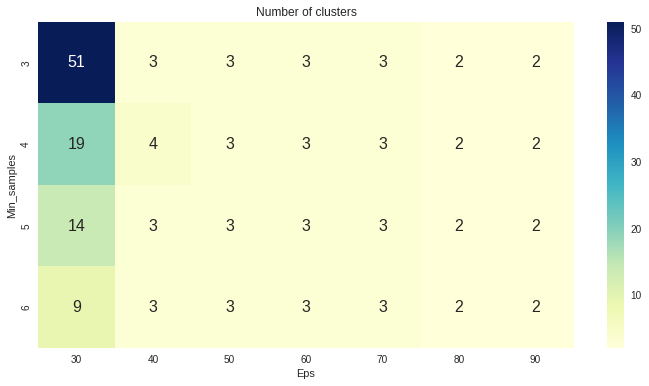

In [38]:

tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['No_of_clusters'] = no_of_clusters

pivot_1 = pd.pivot_table(tmp, values='No_of_clusters', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(12,6))
sns.heatmap(pivot_1, annot=True,annot_kws={"size": 16}, cmap="YlGnBu", ax=ax)
ax.set_title('Number of clusters')
plt.show()

Este heatplot muestra que el modelo va desde 51 a 2 cluster en el espacio de muestreo utilizado. Sin embargo, la mayoría de las combinaciones originan 3 clusters. Para decidir que combinación utlizar se puede usar la métrica de solhuette. 

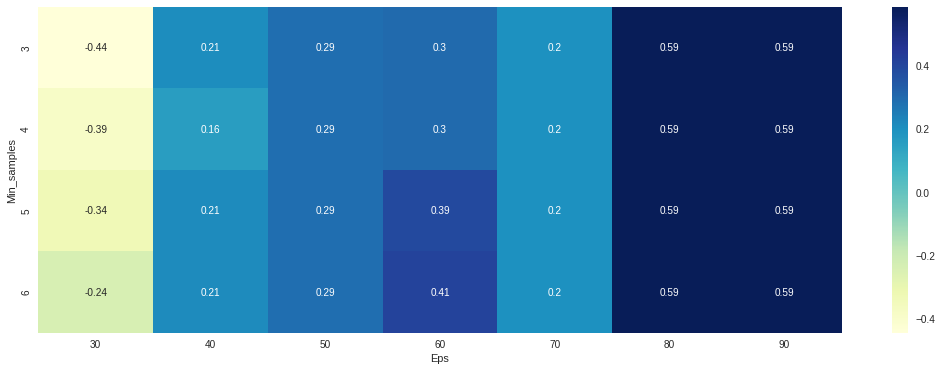

In [39]:
tmp = pd.DataFrame.from_records(DBSCAN_params, columns =['Eps', 'Min_samples'])   
tmp['Sil_score'] = sil_score

pivot_1 = pd.pivot_table(tmp, values='Sil_score', index='Min_samples', columns='Eps')

fig, ax = plt.subplots(figsize=(18,6))
sns.heatmap(pivot_1, annot=True, annot_kws={"size": 10}, cmap="YlGnBu", ax=ax)
plt.show()

Vamos a explorar la combinación de parámetros que obtenemos un score de silhuette de 0.41:
- Eps=60
- Min_samples=6 

In [40]:
DBS_clustering = DBSCAN(eps=60.0, min_samples=6).fit(analysis_dataframe)
DBSCAN_clustered = info_dataframe.copy()
DBSCAN_clustered.loc[:,'Cluster'] = DBS_clustering.labels_ # append labels to points
DBSCAN_clustered.head()
DBSCAN_clustered['Cluster'].value_counts()

 0    17100
 1     2129
-1       10
Name: Cluster, dtype: int64

Aca podemos ver que hay 3 clusters: 1-el principal con 17100 datos, el 2-con 2129 y uno que tiene 3- 10 outliers

## Visualizaciones

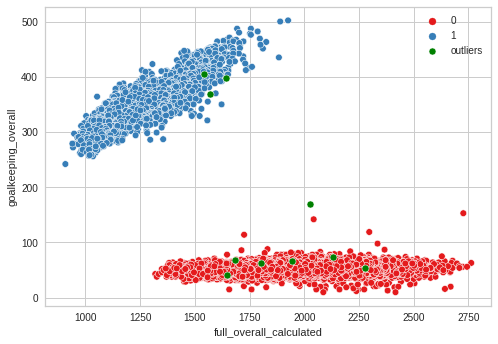

In [41]:
outliers = DBSCAN_clustered[DBSCAN_clustered['Cluster']==-1]

sns.scatterplot('full_overall_calculated', 'goalkeeping_overall',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', palette='Set1', legend='full', s=45)

sns.scatterplot(outliers['full_overall_calculated'], outliers['goalkeeping_overall'], s=50, label='outliers',c=['green'])

plt.show()

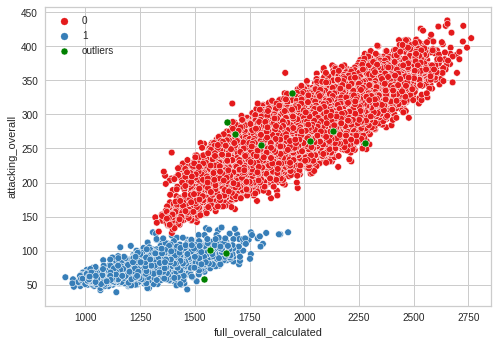

In [42]:
outliers = DBSCAN_clustered[DBSCAN_clustered['Cluster']==-1]

sns.scatterplot('full_overall_calculated', 'attacking_overall',
                data=DBSCAN_clustered[DBSCAN_clustered['Cluster']!=-1],
                hue='Cluster', palette='Set1', legend='full', s=45)

sns.scatterplot(outliers['full_overall_calculated'], outliers['attacking_overall'], s=50, label='outliers',c=['green'])

plt.show()

Hay varios outliers detectados por DBSCAN: resulta interesante entender porqué son outliers y que caracterítica origina eso.

# AgglomerativeClustering

Función para el ploteo de dendogramas que obtuvimos de: https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html

In [43]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    dendrogram(linkage_matrix, **kwargs)

In [44]:
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None)
model = model.fit(analysis_dataframe)

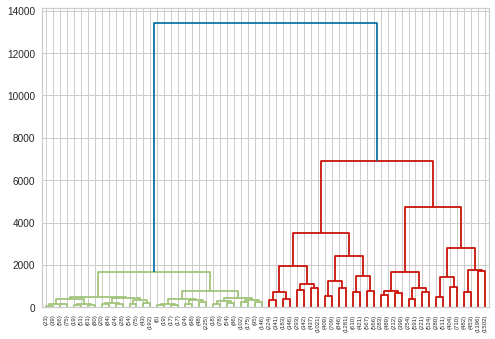

In [45]:
plot_dendrogram(model, truncate_mode="level", p=5)

Calculamos el Silohuette score para un rango definido de clusters.

In [46]:
silhouette_scores = [] 

for n_cluster in range(2, 8):
    silhouette_scores.append( 
        silhouette_score(analysis_dataframe, AgglomerativeClustering(n_clusters = n_cluster).fit_predict(df_3)))

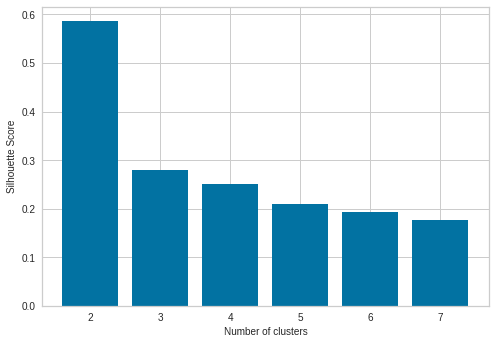

In [47]:
k = [2, 3, 4, 5, 6,7] 
plt.bar(k, silhouette_scores) 
plt.xlabel('Number of clusters', fontsize = 10) 
plt.ylabel('Silhouette Score', fontsize = 10) 
plt.show() 

Se puede ver que el algoritmo logra discriminar con un alto silhoute solo 2 clusters, arqueros por un lado y jugadores por el otro.

Vamos a construir y visualizar el clustering para modelos de 2 clusters.

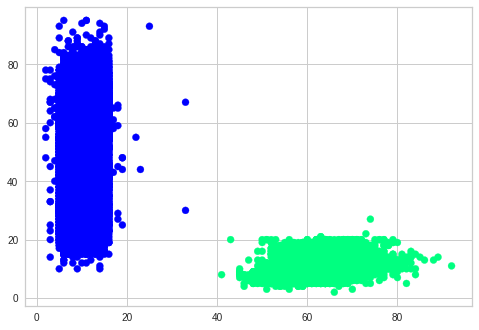

In [48]:
AgglomerativeClustering(affinity='euclidean', compute_full_tree='auto',
                        connectivity=None, distance_threshold=None,
                        linkage='ward', memory=None, n_clusters=2)

plt.scatter(analysis_dataframe['goalkeeping_handling'], analysis_dataframe['attacking_finishing'],  
           c = AgglomerativeClustering(n_clusters = 2).fit_predict(analysis_dataframe), cmap =plt.cm.winter) 
plt.show() 

Podemos ver nuevamente esta diferenciación entre arqueros y el resto de los jugadores.